In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import tensorflow as tf
tf.keras.backend.clear_session()

2022-09-02 02:10:53.994101: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-09-02 02:10:53.994262: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-09-02 02:10:54.047088: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.


# Utils

In [5]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {}
    headers["Host"] = SERVICE_HOSTNAME_CIFAR10
    res = requests.post('http://tfserving-cifar10.kubeflow-profile.svc.cluster.local/v1/models/tfserving-cifar10:predict', json=formData)
    if res.status_code == 200:
        j = res.json()
        if len(j["predictions"]) == 1:
            return classes[np.array(j["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
def drift(X):
    formData = {
    'instances': X.tolist()
    }
    headers = { "ce-namespace": "default","ce-modelid":"cifar10drift","ce-type":"io.seldon.serving.inference.request", \
                "ce-id":"1234","ce-source":"localhost","ce-specversion":"1.0"}
    headers["Host"] = SERVICE_HOSTNAME_VAEOD    
    res = requests.post('http://drift-detector.kubeflow-profile.example.com', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        return od
    else:
        print("Failed with ",res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Send 1 request

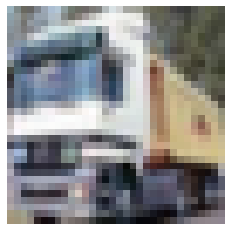

'truck'

In [36]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

In [37]:
# there is nothing in the event-display log yet
!kubectl logs -n kubeflow-profile $(kubectl get pod -n kubeflow-profile -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 

# Send 5000 requests

In [38]:
from tqdm.notebook import tqdm

for i in tqdm(range(0,5000,100)):
    X = X_train[i:i+100]
    predict(X)

  0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
res=!kubectl logs -n kubeflow-profile $(kubectl get pod -n kubeflow-profile -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0, len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Drift",j["data"]["is_drift"]==1)

Drift False


Now, let's create some CIFAR10 examples with motion blur.

In [40]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
corruption = ['motion_blur']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

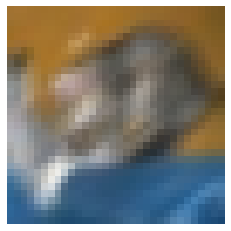

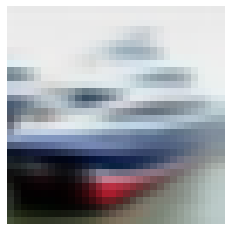

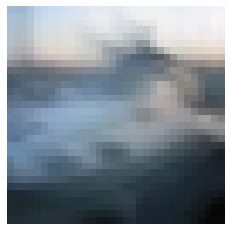

In [41]:
show(X_corr[0])
show(X_corr[1])
show(X_corr[2])

In [46]:
for i in tqdm(range(0,5000,100)):
    X = X_corr[i:i+100]
    predict(X)

  0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
res=!kubectl logs -n kubeflow-profile $(kubectl get pod -n kubeflow-profile -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Drift",j["data"]["is_drift"]==1)

Drift True
